In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm.notebook import trange, tqdm
import time
import pandas as pd

In [4]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [114]:
from numpy import kron, eye as I, exp, trace as tr, diag
from numpy.linalg import inv, eigh, det
from numpy.random import randn

In [6]:
from utils import vec, mat, get_chain_graph, get_random_graph, matrix_derivative_numerical, mat_pow, diagi, vector_derivative_numerical

In [7]:
def get_params(T, N, gamma, beta, random_graph=False, seed=True, p=0.5):
    
    if seed:
        np.random.seed(1)
    
    Y = np.random.normal(size=(N, T)) 
    S = np.random.choice([0, 1], p=[1 - p, p], replace=True, size=(N, T))
    S_ = 1 - S
    Y = Y * S

    K = np.exp(-(np.linspace(0, 3, T)[:, None] - np.linspace(0, 3, T)[None, :]) ** 2) + 1e-4 * I(T)
    
    if random_graph:
        AT, LT = get_random_graph(T)
        AN, LN = get_random_graph(N)
        
    else:
        AT, LT = get_chain_graph(T)
        AN, LN = get_chain_graph(N)

    lamLT, UT = eigh(LT)
    lamLN, UN = eigh(LN)
    lamK, V = eigh(K)
        
    lamT = exp(-beta * lamLT) ** 2
    lamN = exp(-beta * lamLN) ** 2

    HT = UT @ diag(lamT) @ UT.T
    HN = UN @ diag(lamN) @ UN.T
    
    J = np.outer(lamN, lamT) / (np.outer(lamN, lamT) + gamma)
    G = np.outer(lamN, lamT)
    
    return T, N, gamma, beta, Y, S, S_, lamT, lamN, HT, HN, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G


def get_params2(T, N, gamma, beta, random_graph=False, seed=True, p=0.5):
    
    if seed:
        np.random.seed(1)
    
    Y = np.random.normal(size=(N, T)) 
    S = np.random.choice([0, 1], p=[1 - p, p], replace=True, size=(N, T))
    Y = Y * S
    
    if random_graph:
        AT, LT = get_random_graph(T)
        AN, LN = get_random_graph(N)
        
    else:
        AT, LT = get_chain_graph(T)
        AN, LN = get_chain_graph(N)

    
    return T, N, gamma, beta, Y, S, AT, AN, LT, LN

In [8]:
T, N, gamma, beta, Y, S, S_, lamT, lamN, HT, HN, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G = get_params(T=15, N=10, beta=1, gamma=1e-2, random_graph=False)

In [434]:
T, N, gamma, beta, Y, S, AT, AN, LT, LN = get_params2(T=15, N=10, beta=1, gamma=1e-3, random_graph=False)

In [435]:
F_true = mat(inv(diag(vec(S)) + gamma * kron(inv(HT), inv(HN))) @ vec(Y), like=Y)

In [336]:
F_true

array([[-0.7151, -0.5851, -0.7376, -0.5066, -0.034 , -1.398 , -1.369 , -0.6958, -0.236 , -0.2916, -1.3582, -2.0596, -1.4796, -0.2333,  1.0444],
       [-1.3463, -0.8861, -0.8259, -0.6193,  0.3247,  0.102 ,  0.4491,  0.7582,  0.9641,  0.6448, -0.6438, -1.4313, -1.0853, -0.3491,  0.4921],
       [-1.2232, -0.2829, -0.0443, -0.352 ,  0.2123,  0.2989,  0.3444,  0.3739,  0.9519,  0.984 ,  0.0166, -0.4294, -0.2146, -0.1262,  0.1666],
       [-0.5039,  0.8496,  1.3228,  0.6706,  0.5295,  0.1303, -0.4903, -0.5415,  0.4487,  0.7005,  0.0661,  0.2279,  0.7588,  0.6479,  0.6444],
       [-0.9873,  0.4869,  1.1636,  0.8182,  0.6954,  0.3414, -0.2141,  0.0356,  0.9239,  0.6283, -0.4428, -0.2429,  0.6451,  0.7561,  0.6898],
       [-1.7255, -0.3614,  0.3369,  0.4446,  0.5073,  0.3248, -0.1377,  0.0715,  0.6918,  0.4967, -0.4904, -0.5626,  0.1143,  0.1672, -0.076 ],
       [-1.1595, -0.3432, -0.1599,  0.0715,  0.135 ,  0.2621, -0.0411, -0.1481,  0.0688,  0.1249, -0.6983, -1.2095, -0.9352, -0.8404, -1

In [459]:
gammas = np.logspace(-6, 1, 30)

s1 = ConjugateGradientSolver2(Y, S, gamma, beta, beta, LT, LN)
s2 = IterativeSolver(Y, S, gamma, beta, beta, LT, LN)

all_its1 = []
all_its2 = []


for gamma in gammas:
    
    
    F_true = mat(inv(diag(vec(S)) + gamma * kron(inv(HT), inv(HN))) @ vec(Y), like=Y)
    
    s1.set_gamma(gamma)
    s2.set_gamma(gamma)

    F1, its1 = s1.solve()
    F2, its2 = s2.solve()

    all_its1.append(its1)
    all_its2.append(its2)

In [531]:
all_its1[-1] = 3
all_its2[-3] = 1.5

plt.figure()

plt.xscale('log')
plt.yscale('log')


plt.scatter(gammas, all_its1, label='CGM - experimental', alpha=0.8)
plt.scatter(gammas, all_its2, label='SIM - experimental', alpha=0.8)


plt.plot(gammas, 3 * ((1 + gammas) / gammas) ** 0.5, ls='--', label='CGM - theoretical upper bound', alpha=0.8)
plt.plot(gammas, -2 / np.log(1 / (1 + gammas)), ls='--', label='SIM - theoretical upper bound', alpha=0.8)

plt.legend()
        
    
plt.xlabel('$\gamma$')
plt.ylabel('Number of iterations')

plt.savefig('complexity.pdf')

<IPython.core.display.Javascript object>

In [133]:
class Solver:
    
    def __init__(self, S, gamma, beta_t, beta_n, LT, LN):
        
        
        self.N, self.T = Y.shape
        self.S = S
        self.S_ = 1 - S
        
        self.gamma = gamma
        self.beta_t = beta_t
        self.beta_n = beta_n
        
        self.LN = LN
        self.LT = LT
        
        self.lamLT, self.UT = eigh(LT)
        self.lamLN, self.UN = eigh(LN)
        
        self.lamT = exp(-beta_t * self.lamLT) ** 2
        self.lamN = exp(-beta_n * self.lamLN) ** 2
        
        self.HT = self.UT @ diag(self.lamT) @ self.UT.T
        self.HN = self.UN @ diag(self.lamN) @ self.UN.T

        self.G = np.outer(self.lamN, self.lamT)
        self.J = self.G / (self.G + gamma)
        
    def solve(self, Y, tol=1e-4):
        raise NotImplementedError
        
    def set_gamma(self, gamma):
        self.gamma = gamma
        self.J = self.G / (self.G + gamma)

        
class IterativeSolver(Solver):
    
    def __init__(self, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(S, gamma, beta_t, beta_n, LT, LN)
        
    def solve(self, Y, tol=1e-4):
        
        
        X = self.UN @ (self.J * (self.UN.T @ Y @ self.UT)) @ self.UT.T

        F = X.copy()

        its = 0

        while np.abs(F - F_true).sum() > self.N * self.T * tol:

            X = self.UN @ (self.J * (self.UN.T @ (self.S_ * X) @ self.UT)) @ self.UT.T
            F += X        
            its += 1

        return F, its
    
    
        
class IterativeSolver2(Solver):
    
    def __init__(self, Y, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(Y, S, gamma, beta_t, beta_n, LT, LN)
        
    def solve(self, tol=1e-4):
        
        self.G_ = self.G ** 0.5
        
        X = self.UN @ (self.G_ * (self.UN.T @ self.Y @ self.UT)) @ self.UT.T

        F = X.copy()

        its = 0

        while np.abs(F - F_true).sum() > self.N * self.T * tol:

            X = self.UN @ (self.J * (self.UN.T @ (self.S_ * X) @ self.UT)) @ self.UT.T
            F += X        
            its += 1

        return F, its
    


class SteepestDescentSolver(Solver):
    
    def __init__(self, Y, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(Y, S, gamma, beta_t, beta_n, LT, LN)
        
    def solve(self, tol=1e-4):
        
        B = self.G * (self.UN.T @ self.Y @ self.UT)

        def Ax(X):
            return gamma * X + self.G * (self.UN.T @ (self.S * (self.UN @ X @ self.UT.T)) @ self.UT)

        X = (G / (G + gamma)) * (self.UN.T @ Y @ self.UT)
        R = B - Ax(X)

        dX = np.ones_like(B)

        its = 0

        while np.abs(self.UN @ X @ self.UT.T - F_true).sum() > self.N * self.T * tol:

            alpha = (R ** 2).sum() / (R * Ax(R)).sum()
            dX = alpha * R
            X += dX 
            R = B - Ax(X)
            its += 1

        return self.UN @ X @ self.UT.T, its
    
    
    
class ConjugateGradientSolver(Solver):
    
    def __init__(self, Y, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(Y, S, gamma, beta_t, beta_n, LT, LN)
        
    def solve(self, tol=1e-4):
        
        B = self.G * (self.UN.T @ self.Y @ self.UT)

        def Ax(X):
            return gamma * X + self.G * (self.UN.T @ (self.S * (self.UN @ X @ self.UT.T)) @ self.UT)

        X = (G / (G + gamma)) * (self.UN.T @ Y @ self.UT)  
    
        R = B - Ax(X)
        
        D = R.copy()

        dX = np.ones_like(B)

        its = 0

        while np.abs(self.UN @ X @ self.UT.T - F_true).sum() > self.N * self.T * tol:
            
            AD = Ax(D)
            alpha = (R ** 2).sum() / (D * AD).sum()
            dX = alpha * D
            X += dX 
            R -= alpha * AD
            beta = (R ** 2).sum() / ((R + alpha * AD) ** 2).sum()
            D = R + beta * D
            its += 1
            
        return self.UN @ X @ self.UT.T, its
    
    
class ConjugateGradientSolver2(Solver):
    
    def __init__(self, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(S, gamma, beta_t, beta_n, LT, LN)
        
    def solve(self, Y, tol=1e-4):
        
        self.G_ = self.G ** 0.5
        
        B = self.G_ * (self.UN.T @ Y @ self.UT)

        def Ax(X):
            return gamma * X + self.G_ * (self.UN.T @ (self.S * (self.UN @ (self.G_ * X) @ self.UT.T)) @ self.UT)

        X = np.random.normal(size=self.J.shape) 
#         X = self.G_ * (self.UN.T @ self.Y @ self.UT)

        R = B - Ax(X)
        
        D = R.copy()

        dX = np.ones_like(B)

        its = 0
        
        Rs = [abs(R.sum())]

#         while R.sum() > self.N * self.T * tol:

        for i in range(1000):
            
            AD = Ax(D)
            alpha = (R ** 2).sum() / (D * AD).sum()
            dX = alpha * D
            X += dX 
            R -= alpha * AD
            beta = (R ** 2).sum() / ((R + alpha * AD) ** 2).sum()
            D = R + beta * D
            its += 1
            
            Rs.append(abs(R.sum()))
            
            if np.mean(Rs[-4:]) < tol:
                break
            
        return self.UN @ (self.G_ * X) @ self.UT.T, its
    
    
class ConjugateGradientSolverNaive(Solver):
    
    def __init__(self, Y, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(Y, S, gamma, beta_t, beta_n, LT, LN)
        
        self.HTi = self.UT @ diag(self.lamT ** -1) @ self.UT.T
        self.HNi = self.UN @ diag(self.lamN ** -1) @ self.UN.T
        
    def solve(self, tol=1e-5):
                
        B = self.Y

        def Ax(X):
            return self.S * X + gamma * self.HNi @ X @ self.HTi

        X = np.random.normal(size=self.Y.shape) 
    
        R = B - Ax(X)
        
        D = R.copy()

        dX = np.ones_like(B)

        its = 0

        while np.abs(X - F_true).sum() > self.N * self.T * tol:
            
            AD = Ax(D)
            alpha = (R ** 2).sum() / (D * AD).sum()
            dX = alpha * D
            X += dX 
            R -= alpha * AD
            beta = (R ** 2).sum() / ((R - alpha * AD) ** 2).sum()
            D = R + beta * D
            its += 1
            
            if its > 100000:
                break
            
        return X, its
    

In [10]:
T, N, gamma, Y, S, S_, lamT, lamN, HT, HN, UT, UN, K, lamK, V, J, G = get_params(T=50, N=70, beta=1, gamma=1e-2, random_graph=False)

ValueError: too many values to unpack (expected 17)

In [424]:
Z = np.random.normal(size=Y.shape)
F = UN @ (G ** 0.5 * Z) @ UT.T

<IPython.core.display.Javascript object>


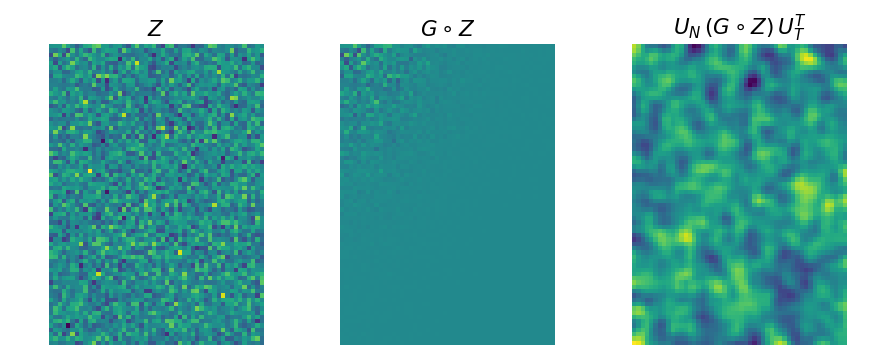

In [427]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4))

axes[0].imshow(Z)
axes[1].imshow(G ** 0.5 * Z, vmin=Z.min(), vmax=Z.max())
axes[2].imshow(F)

# fig.axes('off')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].set_title('$Z$', fontsize='xx-large')
axes[1].set_title('$G \circ Z$', fontsize='xx-large')
axes[2].set_title('$U_N \, (G \circ Z) \, U_T^T$', fontsize='xx-large')

plt.tight_layout()

plt.savefig('spectral_transform.pdf')



In [2]:
from PIL import Image

im = Image.open("pic.jpg").convert('L')

In [90]:
Y_clean = np.array(im)

N, T = Y_clean.shape

T, N, gamma, Y, S, S_, lamT, lamN, HT, HN, UT, UN, K, lamK, V, J, G = get_params(T=T, N=N, gamma=5, beta=5, random_graph=False)

S = np.round(UN @ (G * (UN.T @ S @ UT)) @ UT.T + 2e-2)
S_ = 1 - S

Y_clean = (Y_clean - Y_clean.mean()) / Y_clean.std()


Y_noisy = Y_clean + np.random.normal(size=Y_clean.shape)


S = np.random.choice([0, 1], p=[0.5, 0.5], size=(N, T))

Y_partial = Y_noisy.copy()
Y_partial[S_.astype(bool)] = np.nan


Y = Y_noisy.copy()
Y[S_.astype(bool)] = 0


F, its = get_sol(Y)


<IPython.core.display.Javascript object>


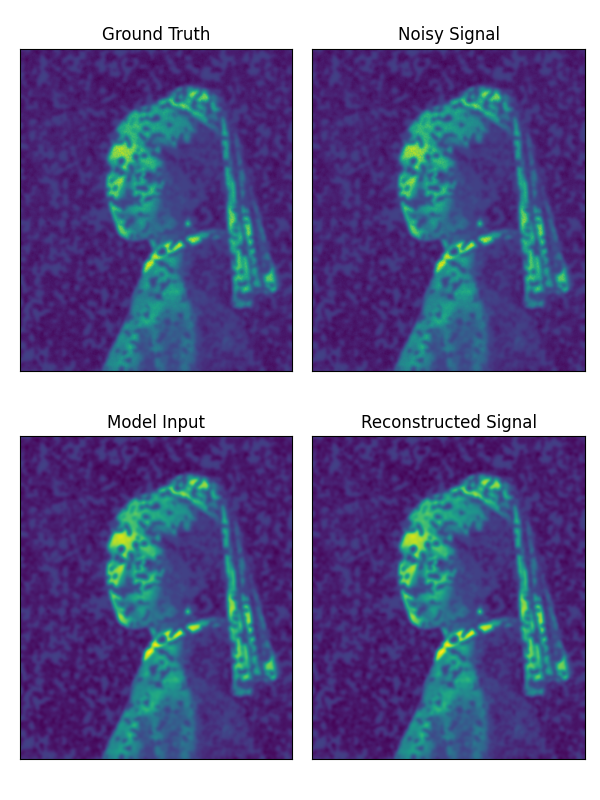

In [99]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(6, 8))

axes[0, 0].imshow(FF2)
axes[0, 1].imshow(FF)
# axes[1, 0].imshow(Y_partial, interpolation='nearest')
axes[1, 1].imshow(F)
axes[1, 0].imshow((HN @ Y @ HT))

    
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_title('Ground Truth')
axes[0, 1].set_title('Noisy Signal')
axes[1, 0].set_title('Model Input')
axes[1, 1].set_title('Reconstructed Signal')

plt.tight_layout()

In [28]:
plt.savefig('Reconstruction.pdf')

In [28]:
T, N, gamma, beta, Y, S, S_, lamT, lamN, HT, HN, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G = get_params(T=50, N=40, beta=1, gamma=1e-2, random_graph=False)

In [10]:
sig_true = inv(diag(vec(S)) + gamma * kron(inv(HT), inv(HN)))

In [1421]:
def active_learn(sig0: float, sigy: float, n_steps: int):
    
    s = ConjugateGradientSolver2(S, gamma, beta, beta, LT, LN)
    
    def get_sigma(i):
        return vec(s.solve(d(i))[0])[i]
    
    F, its = s.solve(Y)
        
    X_all = np.array([np.ones(N * T), 
                      vec(S), 
                      vec((AN @ S + S @ AT) / (AT.sum(0)[None, :] + AN.sum(0)[:, None])), 
                      vec(F), 
                      vec(F) ** 2,
                      kron(diag(HT), diag(HN))]).T
    
    # which order to discover the truth in 
    i0 = np.random.choice(N * T)
    
    X = np.array([X_all[i0, :]])    
    y = [get_sigma(i0)]
    
    X_rem = [x for i, x in enumerate(X_all) if i != i0]
    i_rem = [i for i in range(N * T) if i != i0]
    
    p = X.shape[1]
    
#     Sig0 = sig0 * inv(X_all.T @ X_all) @ X_all.T @ kron(HT, HN) @ X_all @ inv(X_all.T @ X_all)
    Sig0 = sig0 * I(p)
    
    print(Sig0)
    
    Sig = inv(inv(Sig0) + sigy ** -1 * X.T @ X)
    
    for k in range(n_steps):    
        
        uncs = (np.array(X_rem).T * (Sig @ np.array(X_rem).T)).sum(0)
        i = np.argmax(uncs)
        
        
        x = X_rem[i][:, None]
        
        Sig = Sig - (Sig @ x @ x.T @ Sig) / (sigy + x.T @ Sig @ x)
        
        X = np.concatenate([X, x.T], axis=0)
        y.append(np.log(get_sigma(i_rem[i])))
        
        del X_rem[i]
        del i_rem[i]
        
    w = Sig @ X.T @ np.array(y) / sigy        
    preds = X_all @ w
    uncs = (X_all.T * (Sig @ X_all.T)).sum(0) + sigy

    return w, preds, uncs
        
        
        

In [1422]:
w, preds, uncs = active_learn(sig0=2, sigy=0.5, n_steps=100)

[[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]


In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4), sharex=True, sharey=True)

<IPython.core.display.Javascript object>


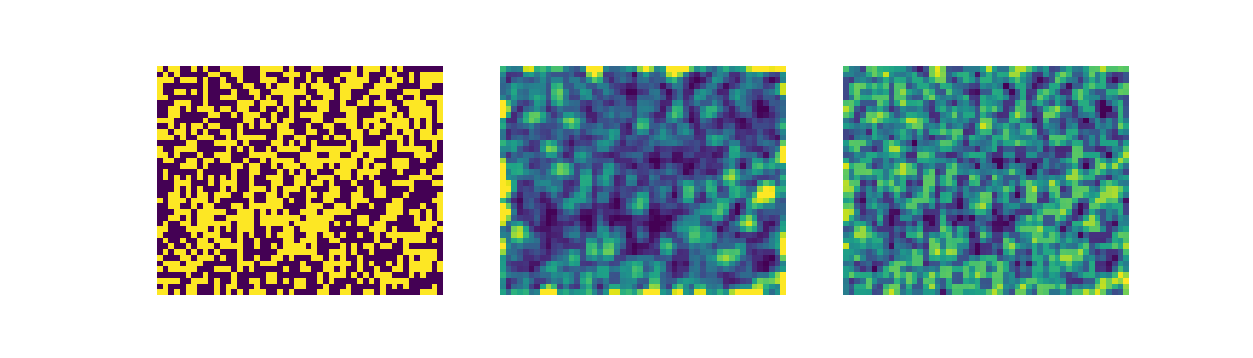

In [1428]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4), sharex=True, sharey=True
                    )

ax[0].imshow(S)
ax[1].imshow(np.log(mat(diag(sig_true), like=J)), vmin=np.log(0.25), vmax=np.log(1.5))
ax[2].imshow(mat(preds, like=J), vmin=np.log(0.25), vmax=np.log(1.5))

for a in ax:
    a.axis('off')

<IPython.core.display.Javascript object>


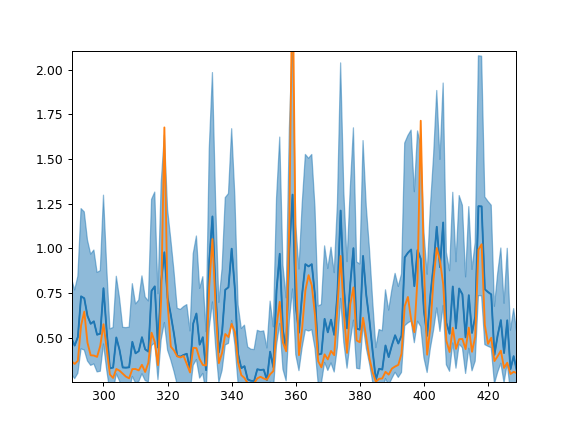

In [1426]:
plt.figure()

plt.plot(np.exp(preds))
plt.plot(diag(sig_true))
plt.fill_between(range(N * T), np.exp(preds), np.exp(preds + uncs), color='tab:blue', alpha=0.5)
plt.fill_between(range(N * T), np.exp(preds), np.exp(preds - uncs), color='tab:blue', alpha=0.5)

In [14]:
s = ConjugateGradientSolver2(S, gamma, beta, beta, LT, LN)



def get_sigma(i):
    return vec(s.solve(d(i))[0])[i]

Q = (AT.sum(0)[None, :] + AN.sum(0)[:, None])

def neighbour_average(S):
    return (AN @ S + S @ AT) / Q
    

F, its = s.solve(Y)
        
X_all = np.array([np.ones(S.shape[0] * S.shape[1]),                                  # constant
                  vec(S),                                                            # observed?
                  vec(neighbour_average(S)),                                         # neighbours observed? 
                  vec(F),                                                            # predicted signal value
                  vec(neighbour_average(F)),                                         # neighbours predicted signal value
                  vec(np.abs(F)),                                                    # absolute predicted signal value
                  vec(neighbour_average(np.abs(F))),                                 # neighbours absolute predicted signal value
                  kron(diag(HT), diag(HN)),                                          # graph filter diagonal
                  vec(neighbour_average(mat(kron(diag(HT), diag(HN)), like=J))),     # neighbours graph filter diagonal
                  4 - vec(Q),                                                        # number of neighbours (transformed)
                  ]).T

X_all[:, 1:] = X_all[:, 1:] / X_all[:, 1:].std(axis=0)
X_all[:, 1:] = X_all[:, 1:] - X_all[:, 1:].mean(axis=0)

NameError: name 'ConjugateGradientSolver2' is not defined

In [1859]:
def q_to_nt(q):
    return ((q - 1) // N + 1, q - ((q - 1) // N) * N)

In [1871]:
def nt_to_q(n, t):
    return (n - 1) * N + t

In [115]:
class KernelRidgeRegression(Model):
    
    def __init__(self, l: float=10):
        
        self.l = l
        
        self.lam = 1
        
        self.p = None
        
        self.X = []
        self.y = []
        
    def get_K(self):
        self.K = np.exp(-squareform(pdist(np.concatenate(self.X, axis=0), metric='sqeuclidean')) / self.l)
    
    def kappa(self, X):
        
        return np.exp(-cdist(X, np.concatenate(self.X, axis=0), metric='sqeuclidean') / self.l)
    
    def get_psi(self):
        
        return np.linalg.solve(self.K + self.lam * I(self.K.shape[0]), np.block(self.y))
    
    def predict(self, X: np.ndarray):
        
        psi = self.get_psi()
        
        if X.shape == (self.p, 1):
            return self.kappa(X.T) @ psi
        
        elif X.shape[1] == self.p:
            return self.kappa(X) @ psi
        
        else:
            raise ValueError(f"X has an invalid shape: {X.shape}")
            
            
    def add_to_data(self, x: np.ndarray, y: float):
        
        if self.p is None:
            self.p = x.shape[0]
        else:         
            assert x.shape == (self.p, 1)
        
        k = self.kappa(x)
        self.K = np.block([[self.K, k.T], [k, 1]])
        self.X.append(x.reshape(-1))
        self.y.append(y)
        
    def set_data(self, X: np.ndarray, y: np.ndarray):
        
        if self.p is None:
            self.p = X.shape[1]
        else:
            assert X.shape[1] == self.p
        
        self.X = [X]
        self.y = [y]
        
        self.get_K()

In [127]:
mod = KernelRidgeRegression(l=20)

In [117]:
q = np.random.choice(N * T, size=50, replace=False)

In [128]:
mod.set_data(X_all[q, :], np.log(diag(sig_true))[q])

In [129]:
pred = mod.predict(X_all)

<IPython.core.display.Javascript object>


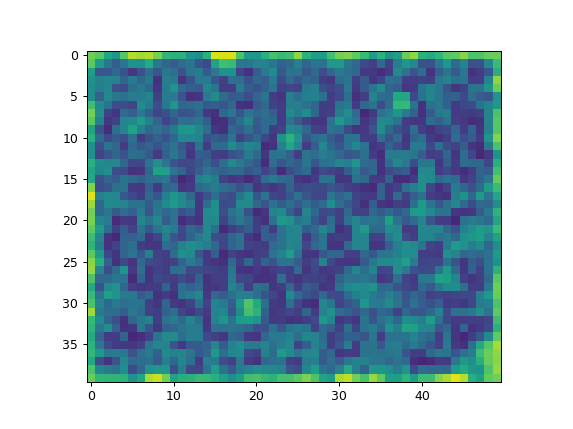

In [130]:
plt.figure()

plt.imshow(mat(pred, like=J), vmin=np.log(0.25), vmax=np.log(1.5))

In [131]:
mod.RMSE(X_all, np.log(diag(sig_true)), exp=False)

0.24600741664440892

In [132]:
mod.RMSE(X_all, diag(sig_true), exp=True)

0.22874456107900673

In [31]:
from scipy.spatial.distance import pdist, cdist, squareform

In [71]:
np.exp(-cdist(np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]), X_all, metric='sqeuclidean') / 10).T

array([[0.    ],
       [0.    ],
       [0.    ],
       ...,
       [0.    ],
       [0.    ],
       [0.0009]])

In [ ]:
plt.figure()

plt.imshow(np.exp(-squareform(pdist(X_all, metric='sqeuclidean')) / 10))

In [114]:
from typing import Callable, List
from sklearn.neighbors import KNeighborsRegressor

class Model:
    
    def predict(self):
        pass
    
    def add_to_data(self, x: np.ndarray, y: float):
        pass
    
    def set_data(self, X: np.ndarray, y: np.ndarray):
        pass
    
    def RMSE(self, X: np.ndarray, y_true: np.ndarray, exp: bool=False):
        if exp:
            return ((np.exp(self.predict(X)) - y_true) ** 2).mean() ** 0.5
        else:
            return ((self.predict(X) - y_true) ** 2).mean() ** 0.5
    
    
    
    
class RidgeRegression(Model):
    
    def __init__(self, sig0: float, sigy: float):
        
        self.sigy = sigy
        self.Sig = sig0 * I(p)
        
        self.p = None

        self.X = []
        self.y = []
        
        
    def get_w(self):
        return self.Sig @ np.concatenate(self.X, axis=0).T @ np.block(self.y) / self.sigy
    
    
    def predict(self, X: np.ndarray):
        
        w = self.get_w()
        
        if X.shape == (self.p, 1):
            return w.T @ X
        elif X.shape[1] == self.p:
            return X @ w
        else:
            raise ValueError(f"X has an invalid shape: {X.shape}")
    
    
    def add_to_data(self, x: np.ndarray, y: float):
        
        if self.p is None:
            self.p = x.shape[0]
        else:         
            assert x.shape == (self.p, 1)
        
        self.Sig -= (self.Sig @ x @ x.T @ self.Sig) / (self.sigy + x.T @ self.Sig @ x)
        self.X.append(x.reshape(-1))
        self.y.append(y)
        
    def set_data(self, X: np.ndarray, y: np.ndarray):
        
        if self.p is None:
            self.p = X.shape[1]
        else:
            assert X.shape[1] == self.p
        
        self.Sig = inv(sig0 ** -1 * I(p) + X.T @ X)
        self.X = [X]
        self.y = [y]
        
        
        
class KernelRidgeRegression(Model):
    
    def __init__(self, l: float):
        
        self.l = l
        
        self.X = []
        self.y = []
        
    def K(self):
        
        pass
    
    def kappa(self, X):
        
        pass
        
        
        
        
    
class KNNRegression(Model):
    
    def __init__(self, k: int, weighted: bool):
        
        self.k = k
        self.weighted = weighted
        self.n = 0
        
        self.p = None

        self.X = []
        self.y = []
        
        
    def add_to_data(self, x: np.ndarray, y: float):
        
        if self.p is None:
            self.p = x.shape[0]
        else:            
            assert x.shape == (self.p, 1)
        
        self.X.append(x.reshape(-1))
        self.y.append(y)
        self.n += 1
        
        if self.n < self.k:
            self.model = KNeighborsRegressor(n_neighbors=self.n, weights='distance' if self.weighted else 'uniform')

        self.model.fit(np.concatenate(self.X, axis=0), np.block(self.y))
        
        
    def predict(self, X: np.ndarray):
        return self.model.predict(X)
        
        
    def set_data(self, X: np.ndarray, y: np.ndarray):
        
        if self.p is None:
            self.p = X.shape[1]
        else:
            assert X.shape[1] == self.p
        
        self.model = KNeighborsRegressor(n_neighbors=min(self.k, X.shape[0]), weights='distance' if self.weighted else 'uniform')
        
        self.n = X.shape[0]
        self.X = [X]
        self.y = [y]        
        
        
        
        

class Committee:
    
    def __init__(self, models: List, X_all: np.ndarray, query_function: Callable):
        
        self.X_all = X_all                              # total population of data
        self.N = X_all.shape[0]

        self.queried = []                               # list of queried indicies
        self.unqueried = list(range(self.N))            # list of unqueried indicies

        self.query_function = query_function            # query function
        self.models = models                            # list of models
        
    def predict(self, X: np.ndarray):
        return np.mean([model.predict(X) for model in self.models], axis=0)
    
    def get_candidate(self):
        return self.unqueried[np.argmax(np.var([model.predict(self.X_all[self.unqueried]) for model in self.models], axis=0))]
#         return np.random.choice(self.unqueried)
        
    def query(self, n: int):
        """
        Query the nth element of the dataset and update all models accordingly 
        """
        
        x = self.X_all[n][:, None]
        y = self.query_function(n)
        
        for model in self.models:
            model.add_to_data(x, y)
            
        self.unqueried.remove(n)
        self.queried.append(n)
        
        return x, y

        
    def estimate(self, n_iters: int=100):
        
        n = np.random.choice(self.N)
        x, y = self.query(n)
        
        for i in range(n_iters):
            
            n = self.get_candidate()
            x, y = self.query(n)
            
        
        
                
    
    
    
    
        

In [19]:
np.concatenate([np.array([[1, 2], [3, 4]]), np.array([[5, 6]])], axis=0)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [20]:
np.block([np.array([1, 2, 3]), 3, 4])


array([1, 2, 3, 3, 4])

In [1672]:
models = [RidgeRegression(sig0=1, sigy=0.5, p=10), 
          RidgeRegression(sig0=2, sigy=0.2, p=10), 
          KNNRegression(k=5, weighted=True, p=10), 
          KNNRegression(k=5, weighted=False, p=10), ]

In [1673]:
com = Committee(models, X_all, lambda i: np.log(get_sigma(i)))

In [1674]:
com.estimate()

In [1778]:
np.mean((com.predict(X_all) - np.log(diag(sig_true))) ** 2) ** 0.5

0.1909955132122036

In [1776]:
np.mean((vec(out) - np.log(diag(sig_true))) ** 2) ** 0.5

0.10996030625130657

In [1777]:
np.mean((np.exp(vec(out)) - diag(sig_true)) ** 2) ** 0.5

0.09262326787386373

In [1676]:
np.mean((models[0].predict(X_all) - np.log(diag(sig_true))) ** 2) ** 0.5

0.2050523801795441

In [1677]:
np.mean((models[1].predict(X_all) - np.log(diag(sig_true))) ** 2) ** 0.5

0.20715821716936803

In [1678]:
np.mean((models[2].predict(X_all) - np.log(diag(sig_true))) ** 2) ** 0.5

0.17548301746280498

In [1679]:
np.mean((models[3].predict(X_all) - np.log(diag(sig_true))) ** 2) ** 0.5

0.21162865067427186

In [1680]:
np.mean((np.exp(com.predict(X_all)) - diag(sig_true)) ** 2) ** 0.5

0.1499237672016736

In [1681]:
np.mean((np.exp(models[0].predict(X_all)) - diag(sig_true)) ** 2) ** 0.5

0.1594877531719861

In [1682]:
np.mean((np.exp(models[1].predict(X_all)) - diag(sig_true)) ** 2) ** 0.5

0.1588225817488395

In [1683]:
np.mean((np.exp(models[2].predict(X_all)) - diag(sig_true)) ** 2) ** 0.5

0.13805865741279422

In [1684]:
np.mean((np.exp(models[3].predict(X_all)) - diag(sig_true)) ** 2) ** 0.5

0.17038511955082805

<IPython.core.display.Javascript object>


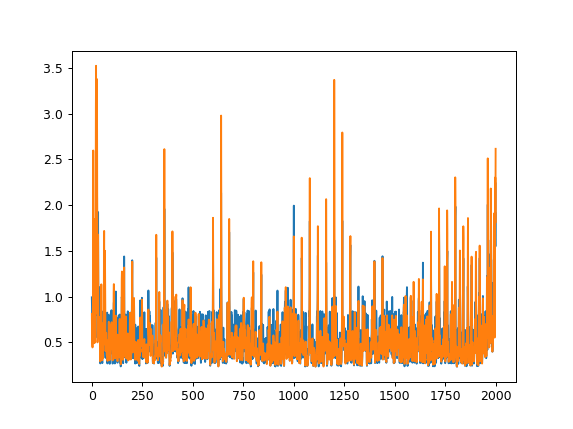

In [1685]:
plt.figure()

plt.plot(np.exp(com.predict(X_all)))
plt.plot((diag(sig_true)))

<IPython.core.display.Javascript object>


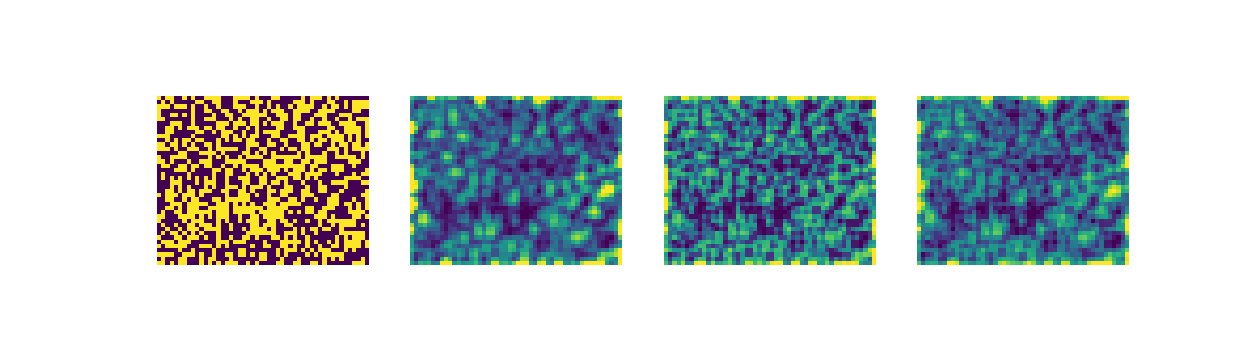

In [1775]:


fig, ax = plt.subplots(ncols=4, figsize=(14, 4), sharex=True, sharey=True
                    )

ax[0].imshow(S)
ax[1].imshow(np.log(mat(diag(sig_true), like=J)), vmin=np.log(0.25), vmax=np.log(1.5))
ax[2].imshow(mat(com.predict(X_all), like=J), vmin=np.log(0.25), vmax=np.log(1.5))
ax[3].imshow(out, vmin=np.log(0.25), vmax=np.log(1.5))

for a in ax:
    a.axis('off')

In [1769]:
d = np.random.choice(X_all.shape[0], size=500, replace=False)

D = np.zeros((500, X_all.shape[0]))
D[range(500), d] = 1

y_D = D @ np.log(diag(sig_true))

In [1770]:
DH = D.T @ D + gamma * kron(inv(HT), inv(HN))

A = np.block([[DH, DH @ X_all], [X_all.T @ DH, X_all.T @ DH @ X_all]])

In [1771]:
A =  np.block([[D.T @ D + gamma * kron(inv(HT), inv(HN)),            D.T @ D @ X_all],
               [        X_all.T @ D.T @ D,                  X_all.T @ D.T @ D @ X_all + I(10)]])

In [1772]:
w = np.linalg.solve(A, np.block([D.T @ y_D, X_all.T @ D.T @ y_D]))

In [1773]:
out = mat(w[:2000], like=J) + mat(X_all @ w[2000:], like=J)

In [8]:
T, N, gamma, beta, Y, S, S_, lamT, lamN, HT, HN, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G = get_params(T=5, N=4, beta=1, gamma=1e-2, random_graph=False)

In [9]:
Q = np.random.randint(2, size=(N, T))

In [92]:

A_ = (AT.sum(0)[None, :] + AN.sum(0)[:, None])

def neighbour_average(S):
    return (AN @ S + S @ AT) / A_


X = np.array([np.ones(S.shape[0] * S.shape[1]),                                  # constant
                  vec(S),                                                            # observed?
                  vec(neighbour_average(S)),                                         # neighbours observed? 
                  kron(diag(HT), diag(HN)),                                          # graph filter diagonal
                  vec(neighbour_average(mat(kron(diag(HT), diag(HN)), like=J))),     # neighbours graph filter diagonal
                  4 - vec(A_),                                                        # number of neighbours (transformed)
                  ]).T

P = X.shape[1]

# X[:, 1:] = X[:, 1:] / X[:, 1:].std(axis=0)
# X[:, 1:] = X[:, 1:] - X[:, 1:].mean(axis=0)

In [211]:
DG = diag(vec(G))
DQ = diag(vec(Q))
U = kron(UT, UN)

lamX, V = eigh(X.T @ DQ @ X)
DX = diag((lamX + 1) ** -0.5)

In [212]:
A11 = DG @ U.T @ DQ @ U @ DG + gamma * I(N * T)
A12 = DG @ U.T @ DQ @ X @ V @ DX
A21 = A12.T
A22 = I(P)

M = np.block([[A11,   A12], 
              [A12.T, A22]]) 

k = max(eigh(M)[0]) / min(eigh(M)[0])
k

135.81939352757695

In [233]:
class ConjugateGradientSolver2(Solver):
    
    def __init__(self, S, gamma, beta_t, beta_n, LT, LN):
        super().__init__(S, gamma, beta_t, beta_n, LT, LN)
        
    def solve(self, Y, tol=1e-4, MAX_ITERS=1000):
        
        self.G_ = self.G ** 0.5
        
        B = self.G_ * (self.UN.T @ Y @ self.UT)

        def Ax(X):
            return gamma * X + self.G_ * (self.UN.T @ (self.S * (self.UN @ (self.G_ * X) @ self.UT.T)) @ self.UT)

        X = np.random.normal(size=self.J.shape) 
#         X = self.G_ * (self.UN.T @ self.Y @ self.UT)

        R = B - Ax(X)
        
        D = R.copy()

        dX = np.ones_like(B)

        its = 0
        
        Rs = [abs(R.sum())]

#         while R.sum() > self.N * self.T * tol:

        for i in range(MAX_ITERS):
            
            AD = Ax(D)
            alpha = (R ** 2).sum() / (D * AD).sum()
            dX = alpha * D
            X += dX 
            R -= alpha * AD
            beta = (R ** 2).sum() / ((R + alpha * AD) ** 2).sum()
            D = R + beta * D
            its += 1
            
            Rs.append(abs(R.sum()))
            
            if np.mean(Rs[-4:]) < tol:
                break
            
        return self.UN @ (self.G_ * X) @ self.UT.T, its
    
    
    def estimate_var(self, tol=1e-4, MAX_ITERS=1000):
        
        
        A_ = (AT.sum(0)[None, :] + AN.sum(0)[:, None])

        def neighbour_average(S):
            return (AN @ self.S + self.S @ AT) / A_
        
        X = np.array([np.ones(self.N * self.T),                                          # constant
                      vec(self.S),                                                            # observed?
                      vec(neighbour_average(self.S)),                                         # neighbours observed? 
                      kron(diag(self.HT), diag(self.HN)),                                          # graph filter diagonal
                      vec(neighbour_average(mat(kron(diag(self.HT), diag(self.HN)), like=J))),     # neighbours graph filter diagonal
                      4 - vec(A_),                                                        # number of neighbours (transformed)
                      ]).T
        
        self.P = X.shape[1]
        
        def query(n, t):
            YY = np.zeros_like(self.J)
            YY[n, t] = 1
            return np.log(self.solve(YY)[0][n, t])
        
        nQ = 5
        nq = np.random.choice(self.N * self.T, size=nQ, replace=False)
        
        Q = np.zeros(self.N * self.T)
        Q[nq] = 1
        Q = mat(Q, like=self.J)
        
        lamX, V = eigh(X[nq].T @ X[nq])
        DX = diag((lamX + 1) ** -0.5)
        
        OMEGA_Q = np.zeros_like(self.J)
        
        for n, t in np.argwhere(Q):
            OMEGA_Q[n, t] = query(n, t)
                
        self.G_ = self.G ** 0.5

        PP = X @ V @ DX
        PPs = [mat(PP[:, i], like=J) for i in range(P)]
        GPs = [G * (UN.T @ (Q * PPs[i]) @ UT) for i in range(P)]
        
        def Mx(v):
            
            A = mat(v[:self.N * self.T], like=self.J)
            a = v[self.N * self.T:]
            
            B1 =  self.G_ * (self.UN.T @ (Q * (self.UN @ (self.G_ * A) @ self.UT.T)) @ self.UT) + self.gamma * A
            B2 = sum(a[i] * GPs[i] for i in range(self.P))
            
            b1 = np.array([(A * GPs[i]).sum() for i in range(self.P)])
            
            return np.block([vec(B1 + B2), b1 + a])

        x = randn(N * T + P) 
        v0 = np.block([vec(self.G_ * (self.UN.T @ OMEGA_Q @ self.UT)), np.array([(PPs[i] * OMEGA_Q).sum() for i in range(self.P)])])
    

        r = v0 - Mx(x)
        
        d = r.copy()

        its = 0
        
        rs = [abs(r.sum())]

#         while R.sum() > self.N * self.T * tol:

        for i in range(MAX_ITERS):
            
            Md = Mx(d)
            alpha = (r ** 2).sum() / (d * Md).sum()
            x += alpha * d
            r -= alpha * Md
            beta = (r ** 2).sum() / ((r + alpha * Md) ** 2).sum()
            d = r + beta * d
            its += 1
            
            rs.append(abs(r.sum()))
            
            if np.mean(rs[-4:]) < tol:
                break
            
        return self.UN @ (self.G_ * mat(x[:N * T], like=self.J)) @ self.UT.T, V @ DX @ x[N * T:], its, Q, v0
    
    

In [234]:
s = ConjugateGradientSolver2(S, gamma, beta, beta, LT, LN)


In [235]:
Alpha, Beta, its, Q, v0 = s.estimate_var()

In [236]:
Alpha + mat(X @ Beta, like=J)

array([[ 1.4652,  2.3128,  2.6341,  3.534 ,  1.3794],
       [ 0.0834,  1.5056,  1.1813,  2.5457, -0.4319],
       [-0.3938,  0.1563, -2.439 , -0.8088,  1.6276],
       [ 3.506 , -0.6993,  0.7862,  1.4411,  4.3369]])

In [237]:
DG = diag(vec(G ** 0.5))
DQ = diag(vec(Q))
U = kron(UT, UN)

lamX, V = eigh(X.T @ DQ @ X)
DX = diag((lamX + 1) ** -0.5)

In [238]:
A11 = DG @ U.T @ DQ @ U @ DG + gamma * I(N * T)
A12 = DG @ U.T @ DQ @ X @ V @ DX
A21 = A12.T
A22 = I(P)

M = np.block([[A11,   A12], 
              [A12.T, A22]]) 

In [242]:
out = np.linalg.solve(M, v0)

Alpha_, Beta_ = UN @ (G ** 0.5 * mat(out[:N * T], like=J)) @ UT.T, V @ DX @ out[N * T:]

In [243]:
Alpha_

array([[ 0.5502, -0.879 , -1.9035, -1.2097,  0.2459],
       [ 3.0372,  1.1943,  0.1284,  1.5964,  3.9886],
       [ 7.5967,  5.202 ,  4.2172,  7.0239, 10.9401],
       [11.7036,  8.9548,  8.1515, 12.1082, 17.2637]])

In [244]:
Beta_

array([ 5.5246, -0.988 , -0.9591, -0.6499,  5.445 , -0.4649])

In [245]:
Alpha

array([[2.5934, 2.2491, 2.0435, 2.2036, 2.5003],
       [2.0659, 1.5534, 1.259 , 1.5455, 2.0292],
       [1.6407, 0.8746, 0.4378, 0.9029, 1.6574],
       [1.6541, 0.6978, 0.1466, 0.735 , 1.6828]])

In [246]:
Beta

array([-0.6481, -0.4686, -0.3979, -0.0187, -0.3979,  0.4866])

In [ ]:
A11 = 

M = np.block([[A11,   A12], 
              [A12.T, A22]]) 

In [ ]:

def conjugate_gradient(A, b, x=None, max_iter=512, reltol=1e-2, verbose=False):
    """
    Implements conjugate gradient method to solve Ax=b for a large matrix A that is not
    computed explicitly, but given by the linear function A. 
    """
    if verbose:
        print("Starting conjugate gradient...")
    if x is None:
        x=np.zeros_like(b)

    # cg standard
    r=b-A(x)
    d=r
    rsnew=np.sum(r.conj()*r).real
    rs0=rsnew

    if verbose:
        print("initial residual: {}".format(rsnew))

    ii=0
    while ((ii<max_iter) and (rsnew>(reltol**2*rs0))):
        ii=ii+1
        Ad=A(d)
        alpha=rsnew/(np.sum(d.conj()*Ad))
        x=x+alpha*d
        if ii%50==0:
            #every now and then compute exact residual to mitigate
            # round-off errors
            r=b-A(x)
            d=r
        else:
            r=r-alpha*Ad

        rsold=rsnew
        rsnew=np.sum(r.conj()*r).real
        d=r+rsnew/rsold*d

        if verbose:
            print("{}, residual: {}".format(ii, rsnew))
    return x